# Lecture 7: Introduction to images

*This lecture was generated from a Jupyter notebook.  You can download the notebook [here](l07_intro_to_images.ipynb).*

In [2]:
import warnings

# Our numerical workhorses
import numpy as np

# Scikit-image submodules
import skimage.filters
import skimage.io
import skimage.morphology

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## What is an image?

To answer this question, we will take a common sense approach and load in what we commonly think of as an image, a TIFF (tagged index file format) file.  We will use `scikit-image` to load the image, and we will cover this package in depth in the coming weeks.

In [3]:
# Load the image
im = skimage.io.imread('../data/HG104_bf_uneven_lighting.tif')

# What is it?
im

array([[389, 398, 419, ..., 362, 373, 390],
       [387, 401, 407, ..., 378, 377, 361],
       [392, 402, 404, ..., 368, 367, 372],
       ..., 
       [366, 389, 380, ..., 353, 363, 348],
       [383, 382, 377, ..., 355, 352, 363],
       [376, 387, 378, ..., 358, 356, 372]], dtype=uint16)

So, a digital image is an array of numbers.  We have stored it as a NumPy array.  What do these numbers represent?

### Pixels
A pixel is a count of photons that struck a particular portion of a charge coupled device (CCD).

A pixel is **not** a square.  A pixel has no width or height.  Yes, typically the region of the CCD for which a pixel is recorded is square, but a photon can strike anywhere within that square, and the count for that pixel is incremented.  We do not know where on the region of the CCD the photons struck, so we define the location of the pixel as the centroid of the CCD region (or the center of the square).  

So, a pixel has a corresponding location on the CCD that can be indexed.  Usually when we say "pixel," we mean to specify the indexed location on the CCD and associated photon count.

The pixels are separated by a physical distance in the camera.  Combined with the optics, this corresponds to a **interpixel distance**, which is the physical distance between pixels in a digital image.  This is commonly referred to as pixel width, but there is no such thing as pixel width, so we will use the term interpixel distance.

Importantly, from this look at pixels, we have learned what a digital image is.  **A digital image is data.**

### Bit depth
Notice that the image as `dtype` `uint16`.  This means that it is an array of 16 bit integers.  A bit is either a one or zero, and the bit depth is the number of bits necessary to represent all of the integer photon counts that the CCD in your device can detect.  For a 16-bit image, then, the total number of possible pixel values is $2^{16} = 65,536$.  So, the pixel values range from 0 to 65,535.

Most cameras that you have used as 8-bit cameras.  This is because the human eye cannot discern differences finer than about 200 intensity levels.  Eight bits gives us 256 intensity levels.

However, **images are data**, so we need not be able to discern differences using our eyes.

The particular image we just loaded is actually not 16-bit.  Let's look at the maximum value.

In [4]:
im.max()

1023

The maximum value is 1023, which is the maximum value we can obtain with a 10-bit camera, since $2^{10} = 1024$.  It is stored as a 16-bit integer because NumPy only supports 8-bit and 16-bit data types for integers, in addition to Python's built in long integers.

## "Plotting" images
An image is data, and that's how we should view them.  Sometimes, it is useful to look at an image.  This "looking" different from looking at pictures of your family or the Grand Canyon.  When we look at scientific digital images, we are **plotting them**.  As with any other data, there are many ways to plot them.  We'll start with a plot that is probably most familiar to you; just looking at the grayscale image.

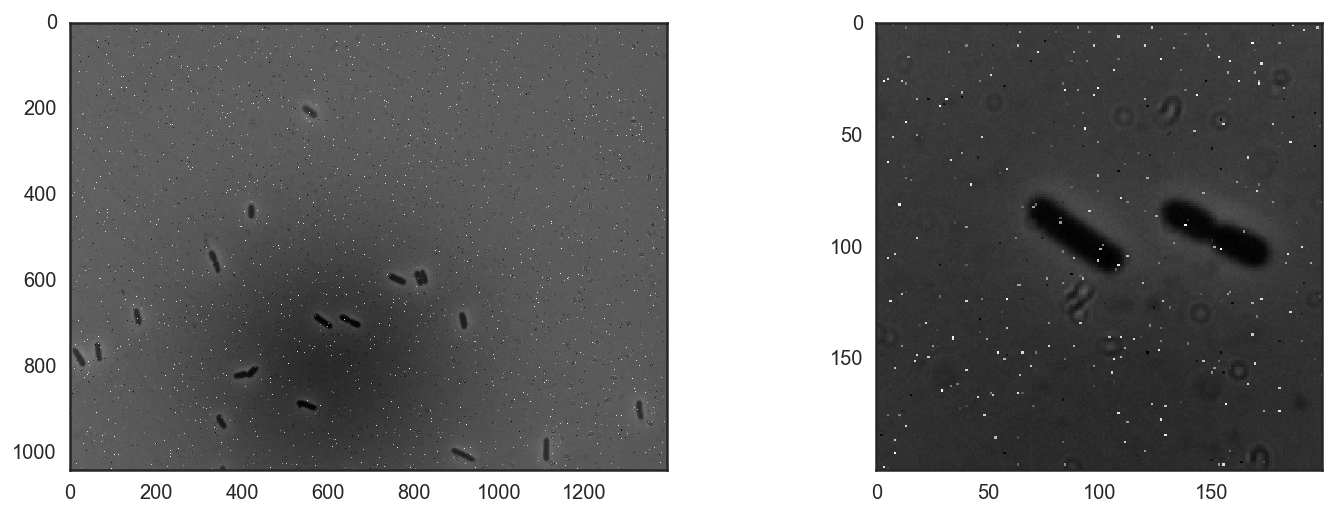

In [5]:
# Display the image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].imshow(im, cmap=plt.cm.gray)
    ax[1].imshow(im[600:800,500:700], cmap=plt.cm.gray)

We recognize the image as bacteria along with some illumination and noise problems.  But, this is not the only way to plot the image!

### False coloring (lookup table)
A **lookup table** is a specification of color for a given pixel value.  In the first plot we made of the image, we used a lookup table where pixels with high intensity were displayed as white and those with low intensity as black.  We can define whatever lookup table we like.  For example, we could make high pixels red and low pixels blue, with intermediate ones being white.

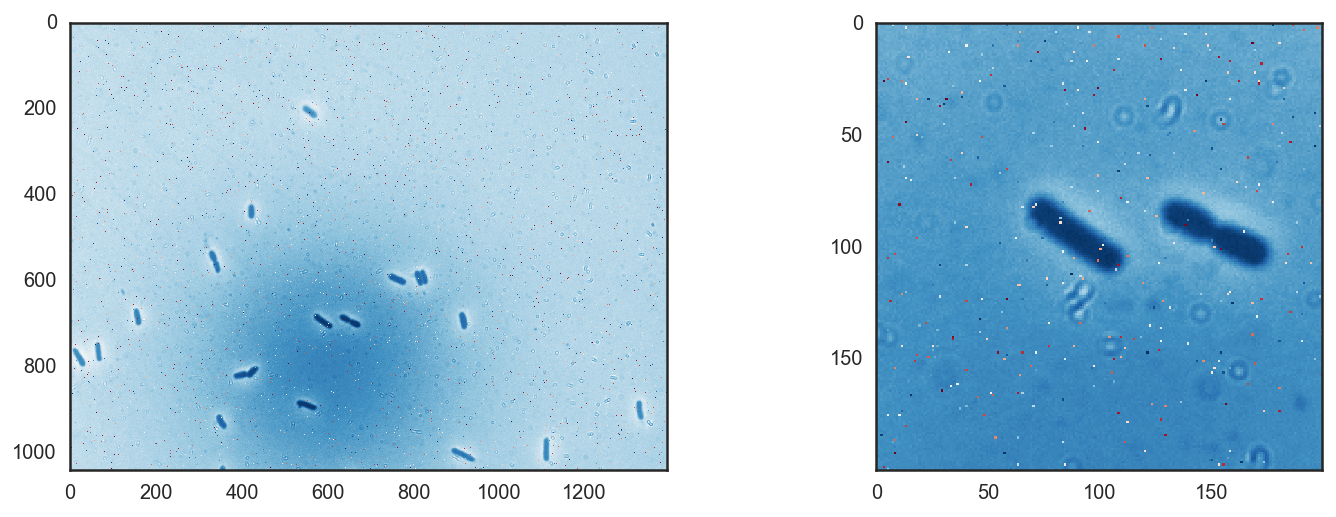

In [6]:
# Display the image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].imshow(im, cmap=plt.cm.RdBu_r)
    ax[1].imshow(im[600:800,500:700], cmap=plt.cm.RdBu_r)

Here, we see that most pixels are blue, and there are a few red ones.  This is indicative of **salt and pepper noise**, where certain pixels have very high intensities.  This is easier seen if we plot the image in yet another way.

### Histograms
The **histogram** of an image is just a histogram of pixel intensity counts.  It is another useful way of looking at images.

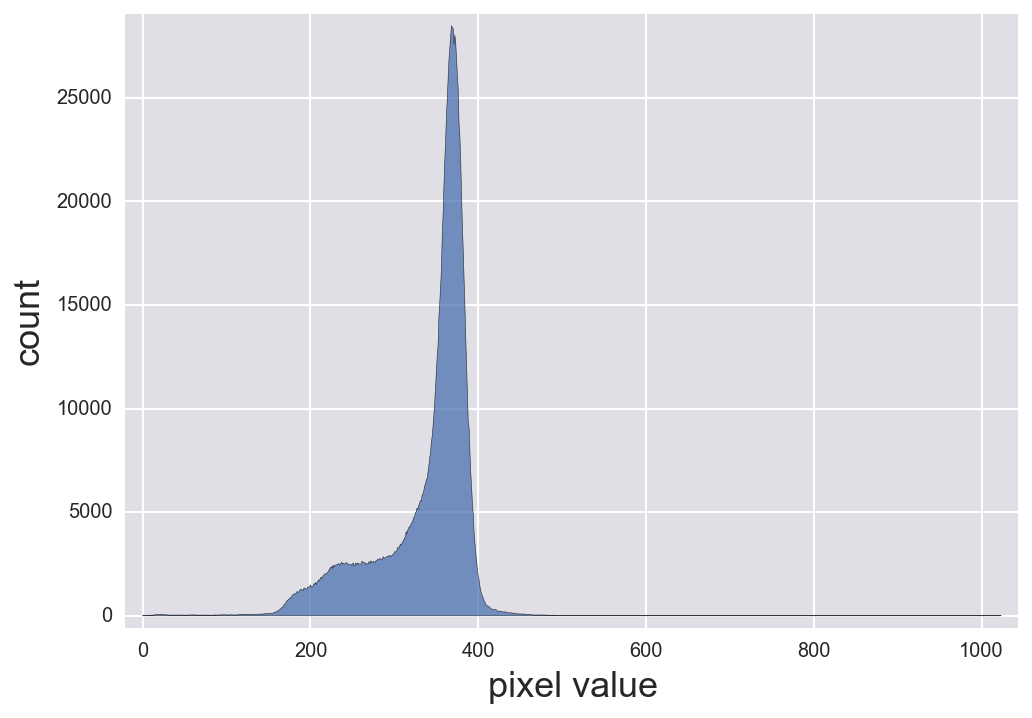

In [7]:
# Get the histogram data
hist, bins = skimage.exposure.histogram(im)

# Use matplotlib to make a pretty plot of histogram data
plt.fill_between(bins, hist, alpha=0.75)

# Label axes and clean up
plt.margins(0.02)
plt.xlabel('pixel value')
plt.ylabel('count')

We see that most pixels lie below 400, and we have a few above 1000.  Similarly, we have  some pixels with values below 175.

## Basic image filtering
We might suspect that the pixel values lying outside of the main peak of the histogram are due to salt and pepper noise.  We can filter this out by doing a **median filter**.  The concept here is simple.  For every 3$\times$3 square subregion of the image, replace the center pixel by the median of the subregion.  

Remember, an image is data, and our goal is to interpret these data.  By filtering, we are helping with this interpretation.

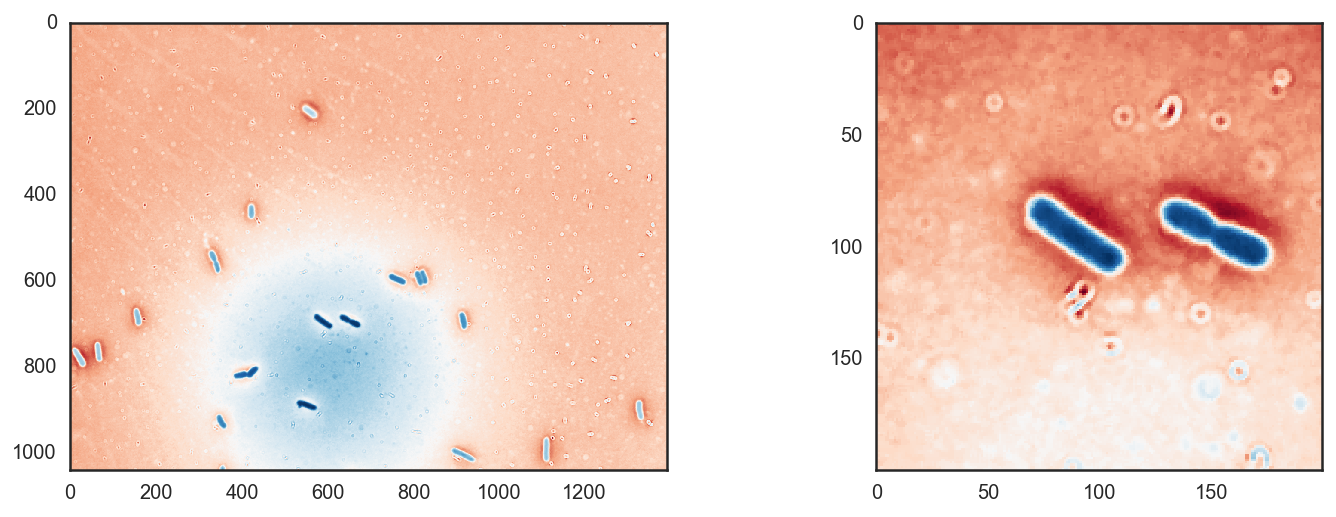

In [8]:
# Make the structuring element
selem = skimage.morphology.square(3)

# Perform the median filter
im_filt = skimage.filters.median(im, selem)

# Show filtered image
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].imshow(im_filt, cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_filt[600:800,500:700], cmap=plt.cm.RdBu_r)

What a difference!  Further, the effects of the uneven illumination are even more pronounced when we look with false coloring.  We can deal with this by **background subtraction**.  To do this, we take a moving average over the image and subtract that average from the whole image.  This process is called **blurring**.  We will take a Gaussian-weighted average, performing a **Gaussian blur**.

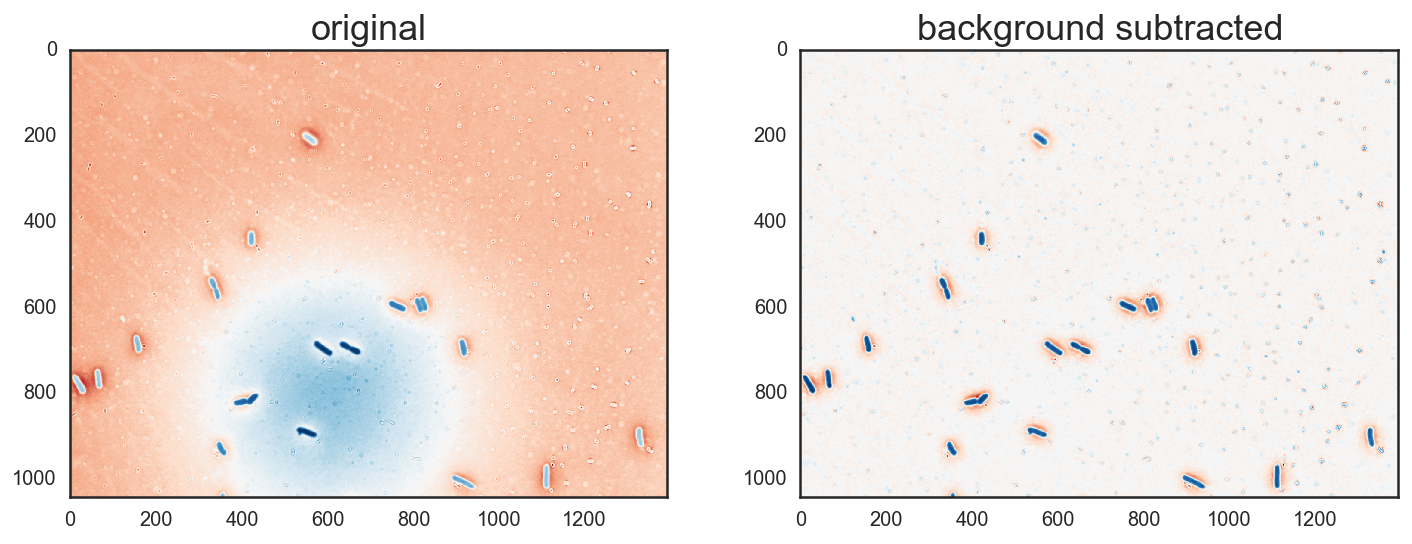

In [9]:
# Convert the uneven image to floating point
im_float = im_filt / im_filt.max()

# Strongly blur the image with a Gaussian filter with stdev of 20 pixels
im_blur = skimage.filters.gaussian_filter(im_float, 20)

# Subtract the blurred image from the original
im_new = im_float - im_blur

# Display images in false color
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(im_float, cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_new, cmap=plt.cm.RdBu_r)
    ax[0].set_title('original')
    ax[1].set_title('background subtracted')

## What is an image more precisely?
We have talked about the end product, a digital image.  But what is an image more precisely?  Again, there are three things we commonly call "image."  We will only call one of them "image" and the other two will get different names.

1. **Digital image**: What we have just described, the digital image.
2. **Image**: What actually comes out of the optics before the CCD detector.  This is what we are trying to store as a digital image.
3. **Object function**: The scene.  That is, the way light is reflected or emitted from an object.  This is what we use the optics of our microscope, telescope, camera, etc., to collect.

We have already discussed how the digital image is acquired from the image.  How are the image and the object function related?

\begin{align}
\text{Image} = \text{PSF} * \text{object function} + \text{noise}.
\end{align}

PSF stands for **point spread function**, which is the way information on the object function is spread as a result of recording data.  This is deterministic and characteristic of the imaging system.  **Noise** is nondeterministic and can, at best, be described with a statistical distribution.  Finally, the $*$ operator is **convolution**.  If $g(x,y)$ is the noiseless image, $f(x',y')$ is the object function, and $h(x, y;x', y')$ is the point spread function,

\begin{align}
g(x,y) = (f*h)(x, y) = \int_{-\infty}^\infty \mathrm{d}x'\,\mathrm{d}y'\,
f(x',y')\,h(x,y;x',y').
\end{align}

We can get a better feel for this with an illustration.

![](psf.png)

If we can independently measure the point spread function exactly, we know $h(x,y;x',y')$ and can perform a **deconvolution**, where we recover something close to the object function from an image.  PSFs are usually measured for a microscope with a point source from, e.g., a quantum dot.  In many cases, deconvolution is done automatically in the acquisition software of the instrument.